Dengfeng's hands on lab expertice , STS test, Foucs on building a Speech to speech Translation demo

Step0 - Install all the prerequisites

In [ ]:
pip install datasets

Step1 - Load Whisper Base(74M)

In [ ]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co./settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Step2 - Load Audio Sample in a non-english language, German

In [ ]:
from datasets import load_dataset

dataset = load_dataset("facebook/voxpopuli", "de", split="validation", streaming=True)
sample = next(iter(dataset))

In [ ]:
from IPython.display import Audio

Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

Step3 - Define a translate function ( from audio to text)

In [ ]:
def translate(audio):
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "translate"})
    return outputs["text"]

translate(sample["audio"].copy())

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=translate, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=translate.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


' The second month is a new president in the field.'

Compare it with the source text

In [ ]:
sample["raw_text"]

'Und seit zwei Monaten ist ein neuer Präsident im Amt.'

Step4 - Text to Speech, TTS, Get the SpeechT5 TTS model to help

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
model.to(device)
vocoder.to(device)

SpeechT5HifiGan(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsampler): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(8,), stride=(4,), padding=(2,))
    (1): ConvTranspose1d(256, 128, kernel_size=(8,), stride=(4,), padding=(2,))
    (2): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(4,), padding=(2,))
    (3): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (1): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256,

In [ ]:
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Step4.1 - Take the text prompt as input, pre-processing

In [ ]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

Get some test of a dummy text input.

In [ ]:
speech = synthesise("Hey there! This is a test!")

Audio(speech, rate=16000)

Step5 - Go to Demo, test the audio function firstly

In [ ]:
import numpy as np

target_dtype = np.int16
max_range = np.iinfo(target_dtype).max


def speech_to_speech_translation(audio):
    translated_text = translate(audio)
    synthesised_speech = synthesise(translated_text)
    synthesised_speech = (synthesised_speech.numpy() * max_range).astype(np.int16)
    return 16000, synthesised_speech

In [ ]:
sampling_rate, synthesised_speech = speech_to_speech_translation(sample["audio"])

Audio(synthesised_speech, rate=sampling_rate)

Step6 - Gradio demo

In [ ]:
pip install gradio

In [ ]:
import gradio as gr

demo = gr.Blocks()

mic_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(sources="microphone", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

file_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(sources="upload", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

with demo:
    gr.TabbedInterface([mic_translate, file_translate], ["Microphone", "Audio File"])

demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a03d3b6dae250fdf76.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co./spaces)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2045, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1592, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", 

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a03d3b6dae250fdf76.gradio.live


Final test we use a german audio input (Und seit zwei Monaten ist ein neuer Präsident im Amt.) , and get a english audio output (And a new president has been in office for two months.), it worked!

Summary:

Build speech to speech translation function as following:
- tanslate audio to text (translated_text = translate(audio))
- translate text to target audio (synthesised_speech = synthesise(translated_text))

to build synthesise:
- using model to drive

then at last import gradio to visualize


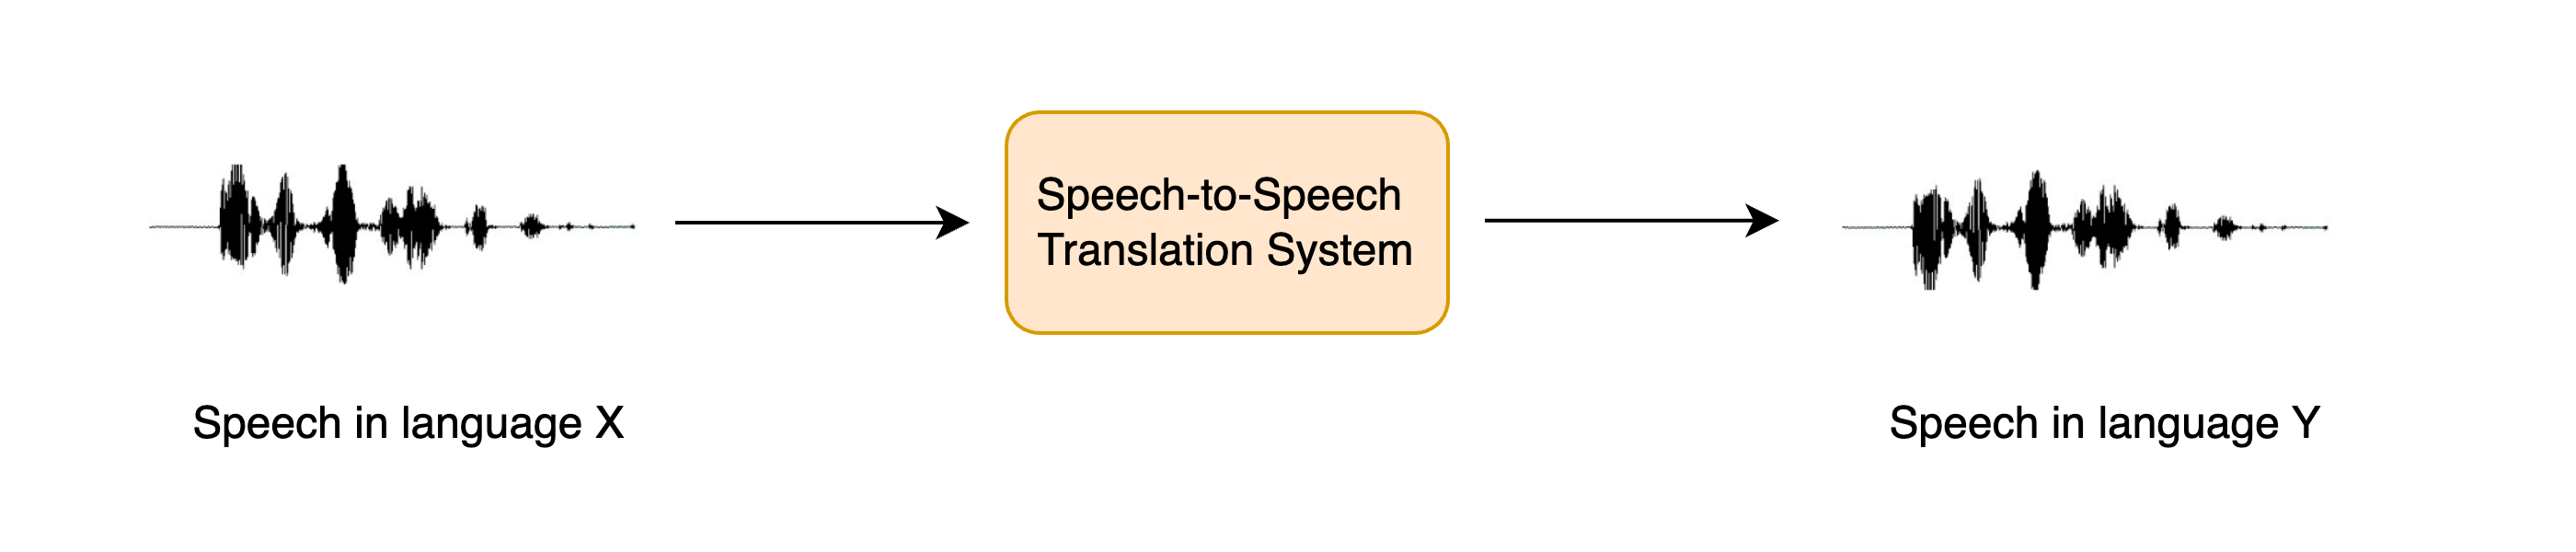
